In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split

### Import Data

In [ ]:
df_train = pd.read_csv('/kaggle/input/feature-generation-dataset/train_dataset.csv', low_memory=False)
df_test = pd.read_csv('/kaggle/input/feature-generation-dataset/test_dataset.csv', low_memory=False)

In [ ]:
df_train.shape, df_test.shape

((1296675, 43), (555719, 43))

In [ ]:
features = ['amt', 'gender_numeric', 'city_pop','cc_count', 'address_multiple_customer_flag', 'fraud_likelihood_merchant', 'fraud_likelihood_category',
            'Latlong_distance','transaction_distance', 'fraud_likelihood_job', 'fraud_likelihood_age', 'address_multiple_card_flag', 'multiple_cards_large_orders',
            'large_order','first_time_shopper', 'is_fraud']

def clean_df(df):
      # Retain only the columns specified in features
    df_cleaned = df[features].copy()
    return df_cleaned

train_df = clean_df(df_train)
test_df = clean_df(df_test)

### Checking if test dataset is 20% of the entire datasets and forming the train test accordingly (no sampling)

In [ ]:
# Placeholder for the target variable name
target_var = 'is_fraud'

# Assess Current Distribution of datasets
total_size = len(train_df) + len(test_df)
current_test_percentage = (len(test_df) / total_size) * 100
print(f"Current test set percentage: {current_test_percentage}%")

Current test set percentage: 30.000043187356468%


In [ ]:
# Resize the Test Set with Stratified Sampling (If Necessary)
if current_test_percentage > 20:
    # Calculate the desired number of test samples to represent approximately 20% of the total data
    desired_test_size = int(total_size * 0.2)

    # Separate features and target variable for stratification
    X_test = test_df.drop(columns=[target_var])
    Y_test = test_df[target_var]

    # Use train_test_split to stratify and reduce the size of the test dataset
    _, x_test, _, y_test = train_test_split(X_test, Y_test, train_size=desired_test_size, stratify=Y_test, random_state=42)

    # Combine the features and target variable back into a downsized test dataframe
    test_df_downsampled = pd.concat([x_test, y_test], axis=1)
else:
    test_df_downsampled = test_df

In [ ]:
# Calculate the number of fraud cases in the downsized test dataset
num_fraud_cases_downsampled = test_df_downsampled['is_fraud'].sum()

# Calculate the total number of cases in the downsized test dataset
total_cases_downsampled = len(test_df_downsampled)

# Calculate the percentage of fraud cases in the downsized test dataset
percentage_fraud_downsampled = (num_fraud_cases_downsampled / total_cases_downsampled) * 100

print(f"Percentage of fraud cases in the downsized test dataset: {percentage_fraud_downsampled:.2f}%")


Percentage of fraud cases in the downsized test dataset: 0.39%


In [ ]:
# Split the Training Data to Create a Validation Set with Stratified Sampling
# Calculate the new ratio for the validation set, given the adjusted test set
remaining_data_size = total_size - len(test_df_downsampled)
validation_ratio = (0.1 * total_size) / remaining_data_size

# Separate features and target variable in the training data for stratification
X_train = train_df.drop(columns=[target_var])
Y_train = train_df[target_var]

# Split the training data to create a validation set, using stratified sampling
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=validation_ratio, stratify=Y_train, random_state=42)

# Combine the features and target variable back into training and validation dataframes
train_df_split = pd.concat([x_train, y_train], axis=1)
val_df_split = pd.concat([x_val, y_val], axis=1)

In [ ]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

In [ ]:
# SMOTE % fraud in train
# Manually apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Count the number of instances per class
counter = Counter(y_train_smote)
print(counter)

# Calculate and print the percentage of fraud data (assuming fraud is the minority class)
total = sum(counter.values())
fraud_percentage = (counter[1] / total) * 100  # Assuming '1' represents fraud
print(f"Percentage of fraud data after SMOTE: {fraud_percentage:.2f}%")

# since we will be using the same random_state, the results of SMOTE will be replicated when we use it in a pipeline

Counter({0: 1145927, 1: 1145927})
Percentage of fraud data after SMOTE: 50.00%


### Models

### Models with SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, roc_curve, precision_score, recall_score, classification_report
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

def model_train_and_evaluate_with_smote(estimator, x_train, y_train, x_test, y_test):
    """
    Train a model with SMOTE and evaluate it, returning performance metrics including F2, Precision, and Recall,
    and also either coefficients or feature importances based on the model.
    """
    # Create a pipeline with SMOTE and the estimator
    pipeline = make_pipeline(SMOTE(random_state=42), estimator)

    # Fit the pipeline
    pipeline.fit(x_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1] if hasattr(estimator, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')

    # ROC curve metrics, if possible
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba) if y_pred_proba is not None else (None, None, None)

    # Attempt to retrieve model coefficients or feature importances
    model_attributes = {}
    if hasattr(estimator, 'coef_'):
        model_attributes['coefficients'] = estimator.coef_
    elif hasattr(estimator, 'feature_importances_'):
        model_attributes['feature_importances'] = estimator.feature_importances_
    else:
        print(f"The model {estimator.__class__.__name__} does not support coefficient or feature importance retrieval.")

    print(f'\nModel with SMOTE: {estimator.__class__.__name__}')
    print('Accuracy:', accuracy)
    print('F1 Score:', f1)
    print('F2 Score:', f2)
    print('Precision:', precision)
    print('Recall:', recall)
    print('AUC Score:', auc if auc is not None else "N/A")
    print(classification_report(y_test, y_pred))

    if 'coefficients' in model_attributes:
        print('Coefficients:\n', model_attributes['coefficients'])
    elif 'feature_importances' in model_attributes:
        print('Feature Importances:\n', model_attributes['feature_importances'])

    return f1, f2, auc, accuracy, precision, recall, fpr, tpr, model_attributes


### Best Model with tuned hyperparameters

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report
from scipy.stats import randint
from imblearn.pipeline import Pipeline as ImbPipeline

# Function to perform hyperparameter tuning, final training, and evaluation
def model_train_evaluate_tune_random_search(estimator, search_spaces, x_train_full, y_train_full, x_test, y_test, scoring_metric, n_iter=100, verbose=10):
    # First, sample a subset of the training data for hyperparameter tuning
    x_train_sampled, _, y_train_sampled, _ = train_test_split(
        x_train_full, y_train_full,
        stratify=y_train_full,
        test_size=0.95,  # Adjust as needed
        random_state=42
    )

    # Perform hyperparameter tuning on the sampled data
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=search_spaces,
        n_iter=n_iter,
        scoring=scoring_metric,
        cv=5,
        n_jobs=-1,
        verbose=verbose,
        random_state=42,
        return_train_score=True
    )

    # Fit RandomizedSearchCV on the sampled dataset
    random_search.fit(x_train_sampled, y_train_sampled)

    # Retrieve the best hyperparameters from the tuning process
    best_hyperparams = random_search.best_params_

    # Create a new model instance with the best hyperparameters for final training on the full training dataset
    final_estimator = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('randomforestclassifier', RandomForestClassifier(
            random_state=13,
            n_estimators=best_hyperparams['randomforestclassifier__n_estimators'],
            max_features=best_hyperparams['randomforestclassifier__max_features'],
            max_depth=best_hyperparams['randomforestclassifier__max_depth'],
            min_samples_split=best_hyperparams['randomforestclassifier__min_samples_split'],
            min_samples_leaf=best_hyperparams['randomforestclassifier__min_samples_leaf'],
        ))
    ])

    # Fit the final model on the full training data
    final_estimator.fit(x_train_full, y_train_full)

    # Predict on the test set with the final model
    y_pred = final_estimator.predict(x_test)
    y_pred_proba = final_estimator.predict_proba(x_test)[:, 1] if hasattr(final_estimator, "predict_proba") else None

    # Calculate and print final evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba) if y_pred_proba is not None else ([], [], [])

    # Retrieve feature importances
    feature_importances = final_estimator.named_steps['randomforestclassifier'].feature_importances_

    print("\nFinal Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC Score: {auc}")
    print(classification_report(y_test, y_pred))
    print("Feature Importances:", feature_importances)

    # Return metrics for both tuning and final evaluation, including feature importances
    return {
        'tuning_best_params': best_hyperparams,
        'name' : 'Tuned Random Forest',
        'f1': f1,
        'f2': f2,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'coefficients/feature importance': feature_importances,
    }


In [ ]:
# Adjusted pipeline using imblearn's Pipeline
pipeline_smote_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=13))
])

# Define your search spaces as before
search_spaces_rf = {
    'randomforestclassifier__n_estimators': randint(50, 150),
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 4),
}

# Assuming definitions of x_train_full, y_train_full, x_test, y_test, and search_spaces_rf are provided elsewhere
rf_tuned_model_metrics = model_train_evaluate_tune_random_search(
    estimator=pipeline_smote_rf,
    search_spaces=search_spaces_rf,
    x_train_full=x_train,
    y_train_full=y_train,
    x_test=x_test,
    y_test=y_test,
    scoring_metric='roc_auc',
    verbose=1
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor


Final Model Evaluation Metrics:
Accuracy: 0.9770
F1 Score: 0.1912
F2 Score: 0.3395
AUC Score: 0.957190860362771
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    184526
           1       0.11      0.70      0.19       715

    accuracy                           0.98    185241
   macro avg       0.55      0.84      0.59    185241
weighted avg       1.00      0.98      0.99    185241

Feature Importances: [5.65829656e-01 1.45654288e-02 9.63261523e-02 0.00000000e+00
 0.00000000e+00 2.67107321e-02 9.29967917e-02 6.40202511e-02
 7.99136623e-03 7.70456601e-03 1.74067141e-02 0.00000000e+00
 0.00000000e+00 1.06376602e-01 7.17393109e-05]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score, recall_score, classification_report, roc_curve
from scipy.stats import loguniform

def model_train_evaluate_tune_random_search(estimator, search_spaces, x_train_full, y_train_full, x_test, y_test, scoring_metric, n_iter=100, verbose=10):
    # First, sample a subset of the training data for hyperparameter tuning
    x_train_sampled, _, y_train_sampled, _ = train_test_split(
        x_train_full, y_train_full,
        stratify=y_train_full,
        test_size=0.95,  # Adjust as needed
        random_state=42
    )

    # Perform hyperparameter tuning on the sampled data
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=search_spaces,
        n_iter=n_iter,
        scoring=scoring_metric,
        cv=5,
        n_jobs=-1,
        verbose=verbose,
        random_state=42,
        return_train_score=True
    )

    # Fit RandomizedSearchCV on the sampled dataset
    random_search.fit(x_train_sampled, y_train_sampled)

    # Retrieve the best hyperparameters from the tuning process
    best_hyperparams = random_search.best_params_

    # Create a new model instance with the best hyperparameters for final training on the full training dataset
    final_estimator = estimator.set_params(**best_hyperparams)

    # Fit the final model on the full training data
    final_estimator.fit(x_train_full, y_train_full)

    # Predict on the test set with the final model
    y_pred = final_estimator.predict(x_test)
    y_pred_proba = final_estimator.predict_proba(x_test)[:, 1]  # Logistic Regression supports predict_proba

    # Calculate and print final evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    print("\nFinal Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(classification_report(y_test, y_pred))

    # Extract coefficients
    try:
        logistic_regression_model = final_estimator.named_steps['logisticregression']
        coefficients = logistic_regression_model.coef_[0]
        print("Coefficients:")
        for i, coef in enumerate(coefficients):
            print(f"Feature {i}: {coef:.4f}")
    except KeyError:
        print("Logistic regression step was not found in the pipeline.")
    except AttributeError:
        print("The logistic regression model does not have coefficients.")


    # Return metrics for both tuning and final evaluation, including coefficients
    return {
        'tuning_best_params': best_hyperparams,
        'name': 'Tuned Logistic Regression',
        'f1': f1,
        'f2': f2,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'coefficients/feature importance': coefficients
    }


In [ ]:
# Adjusted pipeline for Logistic Regression
pipeline_smote_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('logisticregression', LogisticRegression(max_iter=1000, random_state=13))
])

# Define the search space for Logistic Regression
search_spaces_lr = {
    'logisticregression__C': loguniform(1e-5, 100),
    'logisticregression__solver': ['liblinear', 'lbfgs']
}

# Assuming x_train_full, y_train_full, x_test, y_test are defined
lgr_tuned_model_metrics = model_train_evaluate_tune_random_search(
    estimator=pipeline_smote_lr,
    search_spaces=search_spaces_lr,
    x_train_full=x_train,
    y_train_full=y_train,
    x_test=x_test,
    y_test=y_test,
    scoring_metric='roc_auc',
    verbose=1
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Final Model Evaluation Metrics:
Accuracy: 0.9005
F1 Score: 0.0546
F2 Score: 0.1230
AUC Score: 0.8453
Precision: 0.0283
Recall: 0.7441
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    184526
           1       0.03      0.74      0.05       715

    accuracy                           0.90    185241
   macro avg       0.51      0.82      0.50    185241
weighted avg       1.00      0.90      0.94    185241

Coefficients:
Feature 0: 0.0072
Feature 1: -0.0003
Feature 2: -0.0000
Feature 3: -0.0003
Feature 4: 0.0000
Feature 5: -0.0001
Feature 6: -0.0002
Feature 7: -0.0169
Feature 8: -0.0005
Feature 9: 0.0000
Feature 10: -0.0004
Feature 11: 0.0000
Feature 12: 0.0000
Feature 13: -0.0002
Feature 14: -0.0000


### Simple Fully Connected Neural Network (Multi Layer Perceptron)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from imblearn.over_sampling import SMOTE


import torch
import numpy as np

In [ ]:
batch_size = 64

scaler = StandardScaler()

# Fit on the training data
scaler.fit(x_train)

# Transform training, validation, and test data
x_train_norm = scaler.transform(x_train)
x_val_norm = scaler.transform(x_val)
x_test_norm = scaler.transform(x_test)

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(x_train_norm, y_train)


In [ ]:
# Now use the normalized data to create your datasets
train_dataset = TensorDataset(torch.tensor(x_train_norm).float(), torch.tensor(y_train.values).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(x_val_norm).float(), torch.tensor(y_val.values).float())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(torch.tensor(x_test_norm).float(), torch.tensor(y_test.values).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),  # Increased number of neurons
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(128, 256),  # Additional layer with more neurons
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Batch normalization layer
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(256, 128),  # Additional layer
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the model
model = MLP(x_train.shape[1])  # num_features = number of features in x_train


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)

# Training
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        # Wrap train_loader with tqdm for a progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        # Validation step
        model.eval()
        val_preds, val_targets = [], []
        # Optionally wrap val_loader with tqdm for a progress bar
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validating"):
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                val_preds.append(outputs.cpu())
                val_targets.append(labels.cpu())

        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)

        # Calculate F1 score on validation set
        f1 = f1_score(val_targets.numpy(), val_preds.numpy().round())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Validation F1: {f1:.4f}')

num_epochs = 10
train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device=device)

Epoch 1/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 893.48it/s]


Epoch 1/10, Loss: 0.0228, Validation F1: 0.3204


Epoch 2/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 871.96it/s]


Epoch 2/10, Loss: 0.0203, Validation F1: 0.3463


Epoch 3/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 882.02it/s]


Epoch 3/10, Loss: 0.0197, Validation F1: 0.1840


Epoch 4/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 887.49it/s]


Epoch 4/10, Loss: 0.0195, Validation F1: 0.4291


Epoch 5/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 882.53it/s]


Epoch 5/10, Loss: 0.0193, Validation F1: 0.4437


Epoch 6/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 884.05it/s]


Epoch 6/10, Loss: 0.0189, Validation F1: 0.4294


Epoch 7/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 886.28it/s]


Epoch 7/10, Loss: 0.0189, Validation F1: 0.4540


Epoch 8/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 862.29it/s]


Epoch 8/10, Loss: 0.0186, Validation F1: 0.5412


Epoch 9/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 895.50it/s]


Epoch 9/10, Loss: 0.0185, Validation F1: 0.4352


Epoch 10/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 894.71it/s]


Epoch 10/10, Loss: 0.0185, Validation F1: 0.4889


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            test_preds.extend(outputs.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    test_preds = np.array(test_preds).flatten()
    test_targets = np.array(test_targets).flatten()

    # Calculate precision and recall for all thresholds
    precision, recall, thresholds = precision_recall_curve(test_targets, test_preds)

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Replace nan with 0

    # Find the index of the highest F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    binary_preds = test_preds >= optimal_threshold

    # Use the optimal threshold to calculate precision and recall
    precision_at_optimal_threshold = precision_score(test_targets, binary_preds)
    recall_at_optimal_threshold = recall_score(test_targets, binary_preds)


    # Use the optimal threshold to calculate other metrics
    f1 = f1_score(test_targets, test_preds >= optimal_threshold)
    f2 = fbeta_score(test_targets, test_preds >= optimal_threshold, beta=2)
    auc_score = roc_auc_score(test_targets, test_preds)
    accuracy = accuracy_score(test_targets, binary_preds)  # Calculate accuracy
    fpr, tpr, _ = roc_curve(test_targets, test_preds)

    print(f'Optimal Threshold: {optimal_threshold}')
    print(f'Test F1 Score at Optimal Threshold: {f1}')
    print(f'Test F2 Score at Optimal Threshold: {f2}')
    print(f'Test Accuracy: {accuracy}')  # Display accuracy
    print('Precision:', precision_at_optimal_threshold)  # Added Precision
    print('Recall:', recall_at_optimal_threshold)  # Added Recall
    print(f'Test AUC Score: {auc_score}')

    return {
        'name' : 'Multilayer Perceptron',
        'f1': f1,
        'f2': f2,
        'auc': auc_score,
        'accuracy': accuracy,
        'precision': precision_at_optimal_threshold,
        'recall': recall_at_optimal_threshold,
        'fpr': fpr,
        'tpr': tpr,
    }

MLP_model_metrics = evaluate_model(model, test_loader, device)

Optimal Threshold: 0.3736557364463806
Test F1 Score at Optimal Threshold: 0.49226441631504925
Test F2 Score at Optimal Threshold: 0.49060835435940564
Test Accuracy: 0.9961023747442521
Precision: 0.49504950495049505
Recall: 0.48951048951048953
Test AUC Score: 0.9533136498133301


### Plots and Comparisons

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_comparative_roc_curves(models_metrics, model_names):
    """
    Plots ROC curves for multiple models with unique colors for each model's curve.

    :param models_metrics: List of tuples containing (fpr, tpr, auc_score) for each model.
    :param model_names: List of model names as strings.
    """
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(models_metrics)))  # Unique colors for each model

    for (fpr, tpr, auc_score), name, color in zip(models_metrics, model_names, colors):
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})', color=color)

    plt.plot([0, 1], [0, 1], 'k--', label='Baseline (Random Model)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
def plot_metric_comparison(model_metrics_list, metric):
    """
    Plot a comparison of the specified metric across all models with unique colors for each model, including
    value labels on top of the bars.

    Parameters:
    - model_metrics_list: List of dictionaries containing metrics for each model.
    - metric: The metric to compare ('f1', 'precision', 'recall', etc.).
    """
    # Extract model names and the specified metric values
    model_names = [model['name'] for model in model_metrics_list]
    metric_values = [model[metric] for model in model_metrics_list]

    # Define a list of colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_metrics_list)))

    # Generate the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, metric_values, color=colors)
    plt.xlabel('Models')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} Scores Across Models')
    plt.xticks(rotation=45)

    # Adding the text labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3g}', va='bottom', ha='center')

    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [ ]:
# Base models
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()
model4 = xgb.XGBClassifier()
model5 = AdaBoostClassifier()

models = [model1, model2, model3, model4, model5]  # Your model instances
model_names = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XG Boost', 'ADA Boost']
model_metrics_list = []

for model in models:
    f1, f2, auc, accuracy, precision, recall, fpr, tpr, coeff_importance = model_train_and_evaluate_with_smote(model, x_train, y_train, x_test, y_test)
    model_metrics_list.append({
        'name': model.__class__.__name__,
        'f1': f1,
        'f2': f2,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'coefficients/feature importance' : coeff_importance

    })

# Assume that fpr_MLP, tpr_MLP, auc_MLP, f1_MLP, f2_MLP, precision_MLP, recall_MLP are the metrics for your additional models
model_metrics_list.append(MLP_model_metrics)
model_names.extend('Multilayer Perceptron')
model_metrics_list.append(rf_tuned_model_metrics)
model_names.extend('Tuned Random Forest')
model_metrics_list.append(lgr_tuned_model_metrics)
model_names.extend('Tuned Log Regression')


Model with SMOTE: LogisticRegression
Accuracy: 0.9001408975334834
F1 Score: 0.0543911665473878
F2 Score: 0.12254111576910674
Precision: 0.02822730408022497
Recall: 0.7440559440559441
AUC Score: 0.8453360638472763
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    184526
           1       0.03      0.74      0.05       715

    accuracy                           0.90    185241
   macro avg       0.51      0.82      0.50    185241
weighted avg       1.00      0.90      0.94    185241

Coefficients:
 [[ 7.22433911e-03 -1.23490632e-04 -2.16048675e-07 -2.23030005e-04
   0.00000000e+00 -3.71633063e-05 -8.92911807e-05 -1.69247113e-02
  -4.05968595e-04 -6.81897599e-06 -1.87815036e-04  0.00000000e+00
   0.00000000e+00 -7.44158237e-05 -2.17434321e-07]]

Model with SMOTE: RandomForestClassifier
Accuracy: 0.9829681334045919
F1 Score: 0.22271495442227152
F2 Score: 0.36428110896196003
Precision: 0.13516746411483255
Recall: 0.6321678321678321
AUC S

In [ ]:
def evaluate_feature_importance(model_names, feature_names, model_metrics_list):
    """
    Function to evaluate and print out the importance of each feature for each model.
    """
    # Ensure model_metrics_list is not shorter than model_names
    min_length = min(len(model_names), len(model_metrics_list))
    for i in range(min_length):
        model_name = model_names[i]
        print(f"\nModel: {model_name}")
        metrics = model_metrics_list[i]
        if 'coefficients/feature importance' in metrics and metrics['coefficients/feature importance'] is not None:
            coefs_or_importance = metrics['coefficients/feature importance']
            print("Feature importance (coefficients/feature importance):")
            for importance, name in zip(coefs_or_importance, feature_names):
                print(f"{name}: {importance}")
        else:
            print("This model does not provide coefficients or feature importances.")

    # If there are more models than metrics, indicate the missing metrics
    if len(model_names) > len(model_metrics_list):
        print("\nSome models do not have corresponding metrics in model_metrics_list.")


evaluate_feature_importance(model_names, features, model_metrics_list)


Model: Logistic Regression
Feature importance (coefficients/feature importance):
amt: coefficients

Model: Random Forest
Feature importance (coefficients/feature importance):
amt: feature_importances

Model: Decision Tree
Feature importance (coefficients/feature importance):
amt: feature_importances

Model: XG Boost
Feature importance (coefficients/feature importance):
amt: feature_importances

Model: ADA Boost
Feature importance (coefficients/feature importance):
amt: feature_importances

Model: M
This model does not provide coefficients or feature importances.

Model: u
Feature importance (coefficients/feature importance):
amt: 0.5658296559310788
gender_numeric: 0.014565428820963936
city_pop: 0.09632615226136107
cc_count: 0.0
address_multiple_customer_flag: 0.0
fraud_likelihood_merchant: 0.02671073207893939
fraud_likelihood_category: 0.09299679174114268
Latlong_distance: 0.06402025105421615
transaction_distance: 0.00799136622818812
fraud_likelihood_job: 0.007704566006769816
fraud_li

In [ ]:
def aggregate_and_sort_feature_importance(model_metrics_list, feature_names):
    """
    Aggregates feature importances across models and sorts them in decreasing order.

    Parameters:
    - model_metrics_list: List of dictionaries containing model metrics, where each dictionary may contain
                          a key 'coefficients/feature importance' with associated importance values.
    - feature_names: List of feature names.

    Returns:
    - A sorted list of tuples, where each tuple contains (feature_name, average_importance).
    """
    feature_importances = {feature: [] for feature in feature_names}

    # Aggregate feature importances
    for metrics in model_metrics_list:
        if 'coefficients/feature importance' in metrics and metrics['coefficients/feature importance'] is not None:
            for importance, name in zip(metrics['coefficients/feature importance'], feature_names):
                feature_importances[name].append(importance)

    # Calculate average importance
    avg_importances = []
    for feature, importances in feature_importances.items():
        if importances:  # Ensure there's at least one importance value for the feature
            avg_importance = sum(importances) / len(importances)
            avg_importances.append((feature, avg_importance))

    # Sort features by average importance in decreasing order
    avg_importances.sort(key=lambda x: x[1], reverse=True)

    return avg_importances

sorted_features = aggregate_and_sort_feature_importance(model_metrics_list, features)
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


In [ ]:
def evaluate_sorted_feature_importance(model_metrics_list, feature_names):
    """
    Evaluates and prints sorted feature importance for a list of models.

    Parameters:
    - model_metrics_list: A list of dictionaries, where each dictionary contains metrics for a model.
    - feature_names: A list of names for the features used by the models.
    """
    for model_metric in model_metrics_list:
        model_name = model_metric.get('name')
        print(f"Evaluating model: {model_name}")

        if 'coefficients/feature importance' in model_metric:
            importance_data = model_metric['coefficients/feature importance']
            if 'coefficients' in importance_data:
                raw_importances = importance_data['coefficients']
                print(f"Found coefficients for {model_name}")
            elif 'feature_importances' in importance_data:
                raw_importances = importance_data['feature_importances']
                print(f"Found feature_importances for {model_name}")
            else:
                print(f"Neither 'coefficients' nor 'feature_importances' found in 'coefficients/feature importance' for {model_name}.")
        else:
            print(f"No 'coefficients/feature importance' key found for {model_name}.")
            # Print out the keys to help with debugging
            print(f"Available keys: {list(model_metric.keys())}")
            continue

        # Convert to list if it is a numpy array
        if isinstance(raw_importances, (list, np.ndarray)):
            importances = np.array(raw_importances).flatten().tolist()
        else:
            print(f"Unrecognized format for feature importances in {model_name}.")
            continue

        # Sort features by their importance
        sorted_importances = sorted(zip(feature_names, importances), key=lambda x: abs(x[1]), reverse=True)

        # Print sorted features and their importance
        for feature, importance in sorted_importances:
            print(f"{feature}: {importance:.4f}")

        print()

# Assuming 'features' is defined as per your context
# features = ['Feature 1', 'Feature 2', ...] # Define your features accordingly
# Print the structure of model_metrics_list for debugging
evaluate_sorted_feature_importance(model_metrics_list, features)

Evaluating model: LogisticRegression
Found coefficients for LogisticRegression
Latlong_distance: -0.0169
amt: 0.0072
transaction_distance: -0.0004
cc_count: -0.0002
fraud_likelihood_age: -0.0002
gender_numeric: -0.0001
fraud_likelihood_category: -0.0001
large_order: -0.0001
fraud_likelihood_merchant: -0.0000
fraud_likelihood_job: -0.0000
first_time_shopper: -0.0000
city_pop: -0.0000
address_multiple_customer_flag: 0.0000
address_multiple_card_flag: 0.0000
multiple_cards_large_orders: 0.0000

Evaluating model: RandomForestClassifier
Found feature_importances for RandomForestClassifier
amt: 0.5388
city_pop: 0.1159
large_order: 0.1018
fraud_likelihood_category: 0.0883
Latlong_distance: 0.0781
fraud_likelihood_merchant: 0.0294
fraud_likelihood_age: 0.0174
gender_numeric: 0.0147
transaction_distance: 0.0079
fraud_likelihood_job: 0.0076
first_time_shopper: 0.0001
cc_count: 0.0000
address_multiple_customer_flag: 0.0000
address_multiple_card_flag: 0.0000
multiple_cards_large_orders: 0.0000

Ev

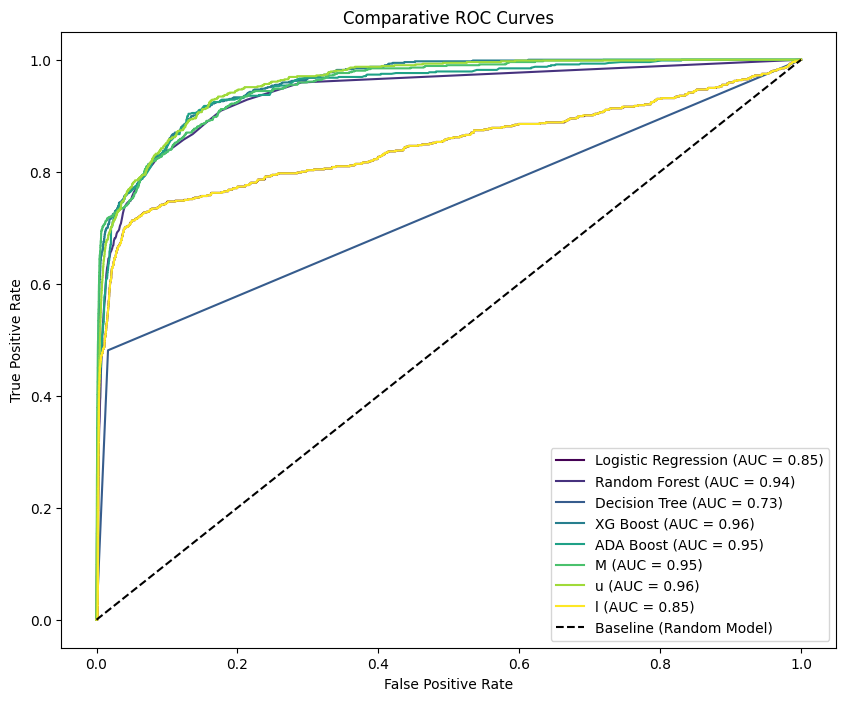

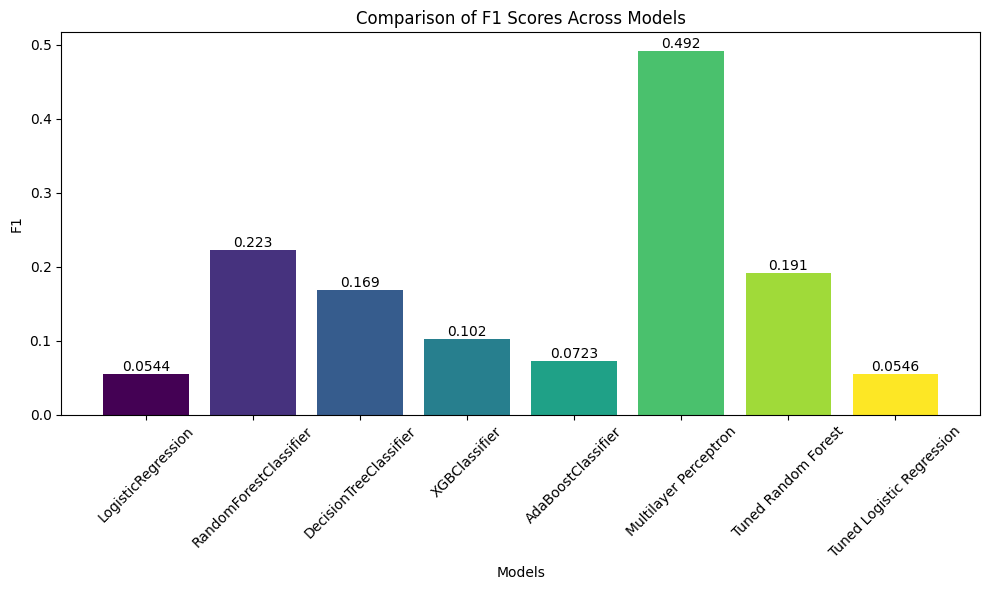

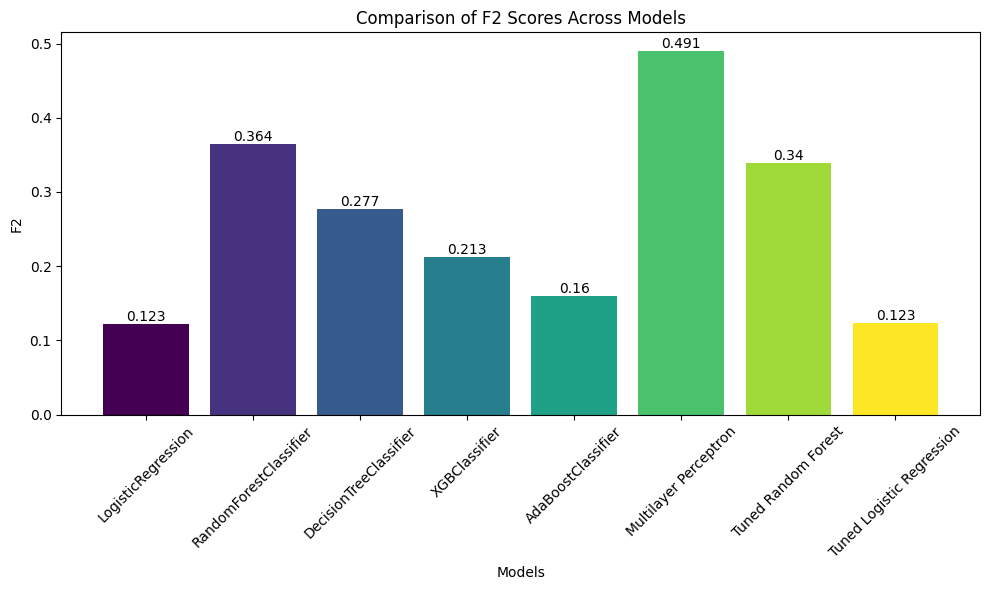

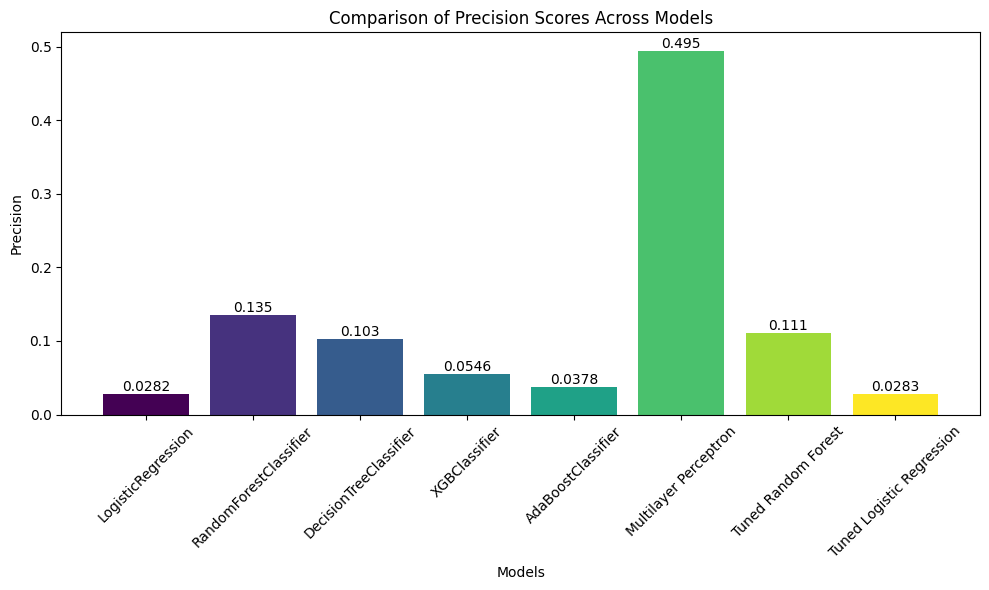

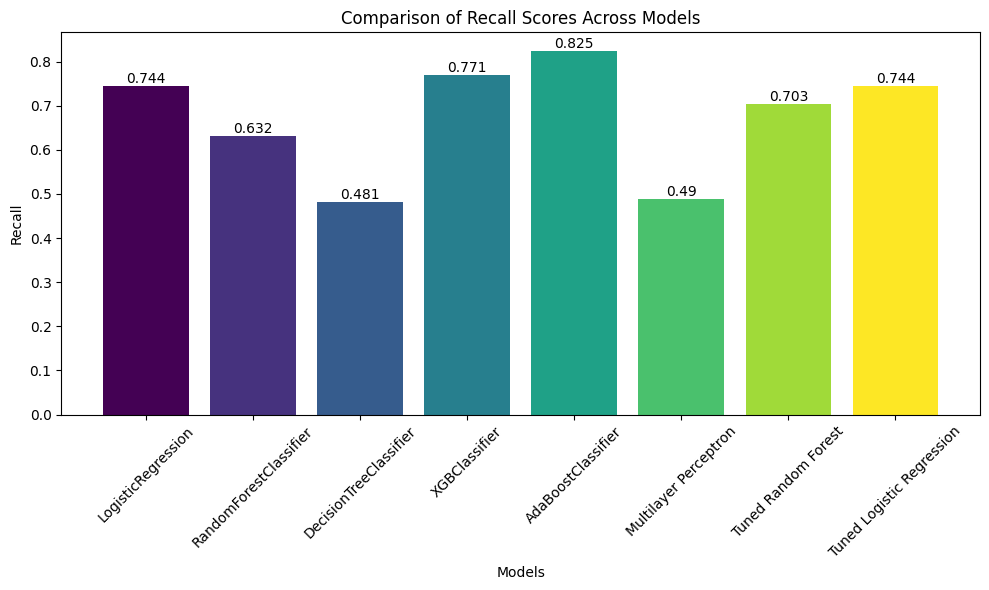

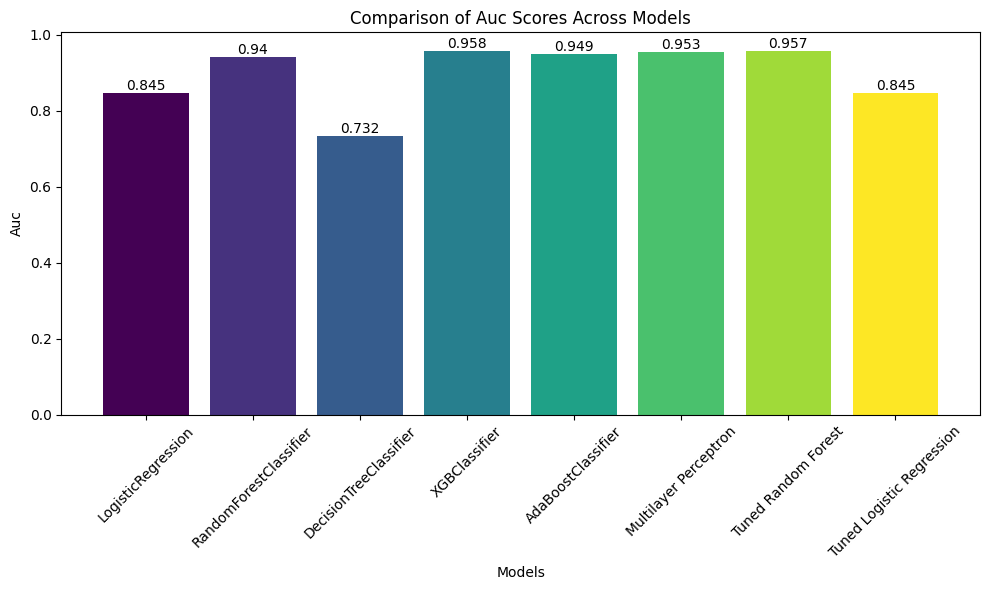

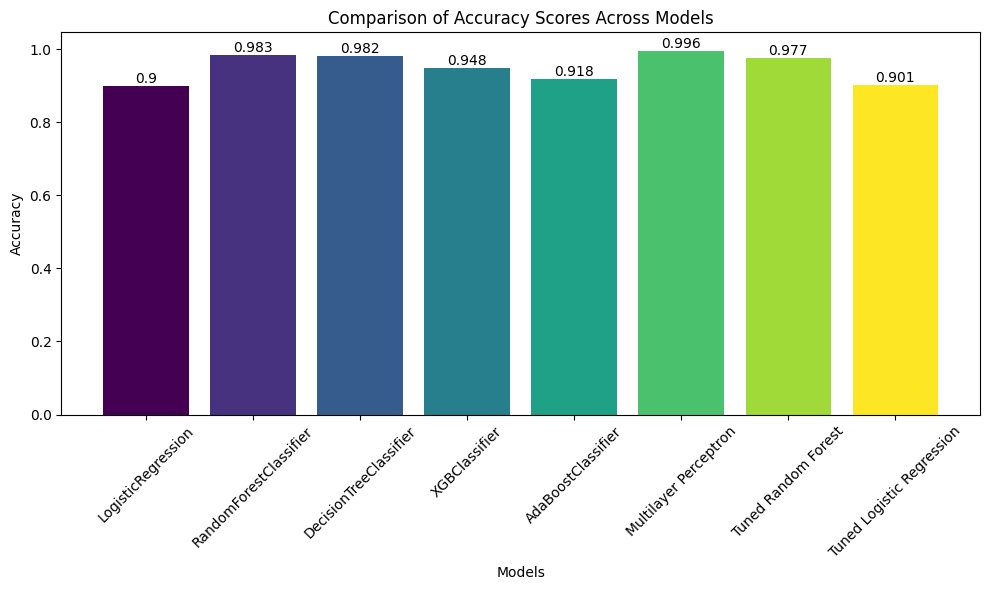

In [ ]:
# Now, you can use the collected metrics to plot ROC curves and compare other metrics as well
# Plotting ROC curves
models_roc_metrics = [(m['fpr'], m['tpr'], m['auc']) for m in model_metrics_list]
plot_comparative_roc_curves(models_roc_metrics, model_names)

# # You can also plot the comparison of F1, F2, Precision, and Recall using the new `plot_metric_comparison` function
# for metric in ['f1', 'f2', 'precision', 'recall']:
#     plot_metric_comparison(model_metrics_list, metric)

# You can also plot the comparison of F1, F2, Precision, and Recall using the new `plot_metric_comparison` function
for metric in ['f1', 'f2', 'precision', 'recall', 'auc', 'accuracy']:
    plot_metric_comparison(model_metrics_list, metric)